In [4]:
%matplotlib inline
import seaborn
import numpy, scipy, matplotlib.pyplot as plt, sklearn
import IPython.display as ipd
import librosa, librosa.display
import subprocess
import sys
import scipy
from numpy.linalg import norm
from sklearn.metrics.pairwise import pairwise_distances

In [51]:
def approximate_pitches(pitches, magnitudes, sr, duration, hop_length, approximation):
    for pitch_index, pitch_track in enumerate(pitches):
        n = 0
        for track_index, inst_pitch in enumerate(pitch_track):
            factor = magnitudes[pitch_index,track_index]
            approximation[n:n+hop_length] += factor*numpy.sin(2 * numpy.pi * inst_pitch * numpy.asarray(range(n,numpy.min([n+hop_length, duration*sr]))) / sr)
            n += hop_length

In [52]:
def extract_tempo(y, sr, hop_length):
    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,hop_length=hop_length)
    ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
    ac_global = librosa.util.normalize(ac_global)
    tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr, hop_length=hop_length)[0]
    return tempo

(44100,)


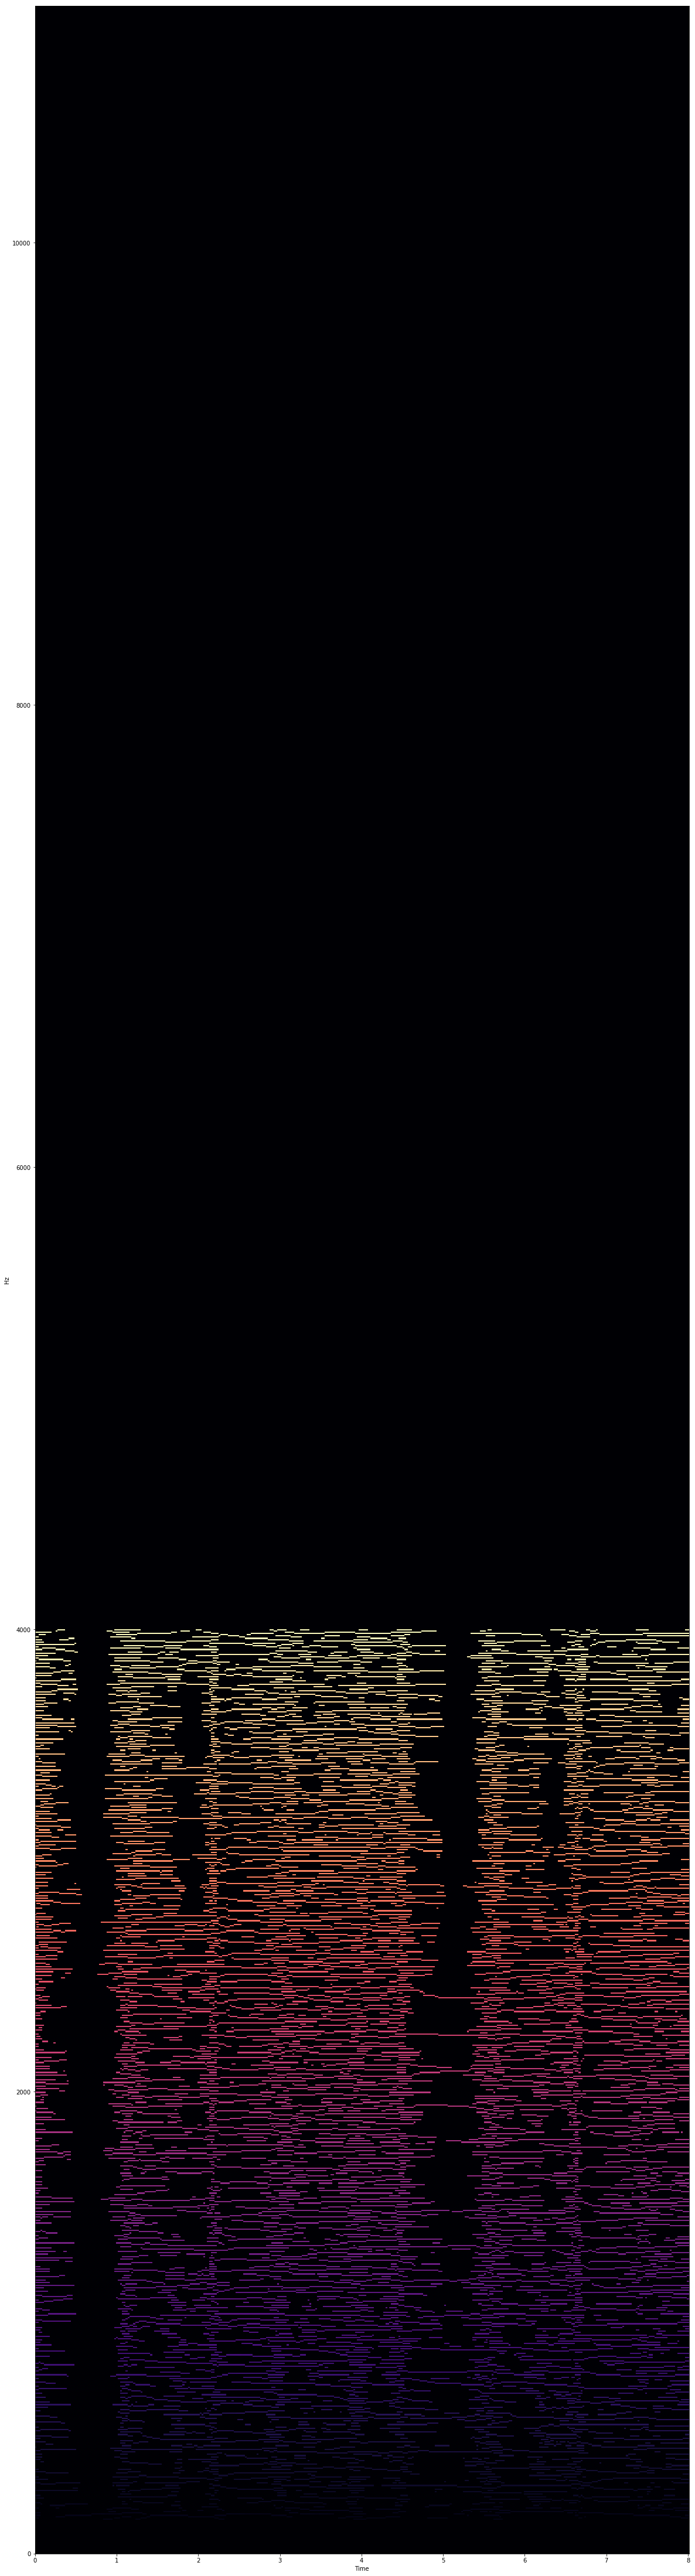

pitches count: 2049
filtered pitches count: 614


In [68]:
offset = 3
duration = 2
x, sr = librosa.load(r'C:\Dev\tools\WavFiles\Kool & The Gang - Get Down On It.wav', offset=offset, duration=duration)
approximation = numpy.zeros(duration*sr)
plt.figure(figsize=(20, 80))
print(x.shape)
#ipd.display(ipd.Audio(x, rate=sr))
#scipy.io.wavfile.write(r'C:\Dev\tools\WavFiles\Kool & The Gang - Get Down On It - processed.wav', sr, x)
hop_length = 128
n_fft = 4096
#D = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)
#plt.subplot(3,1,1)
#librosa.display.specshow(librosa.amplitude_to_db(librosa.magphase(D)[0], ref=numpy.max), y_axis='log', x_axis='time')
pitches, magnitudes = librosa.core.piptrack(x, n_fft=n_fft, hop_length=hop_length, threshold=0.01)
#plt.subplot(3,1,2)
librosa.display.specshow(pitches,y_axis='linear', x_axis='time')
plt.pause(0.1)
#print(pitches.shape)
#plt.subplot(3,1,3)
#librosa.display.specshow(magnitudes[100:110],y_axis='log', x_axis='time')
print("pitches count: {0}".format(pitches.shape[0]))
relevant_pitches_indices = [pitch_index for pitch_index in range(0,pitches.shape[0]) if numpy.average(pitches[pitch_index]) > 0]

print("filtered pitches count: {0}".format(len(relevant_pitches_indices)))
tempo = extract_tempo(x, sr, hop_length)
approximate_pitches(
    pitches[relevant_pitches_indices],
    magnitudes[relevant_pitches_indices]/numpy.amax(magnitudes[relevant_pitches_indices]),
    sr, 
    duration, 
    hop_length, 
    approximation)

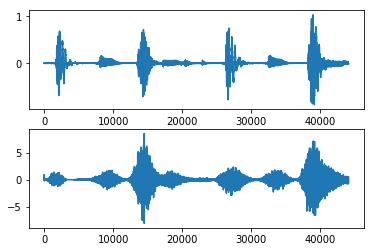

In [69]:
plt.subplot(2,1,1)
plt.plot(x)
ipd.display(ipd.Audio(x, rate=sr))
plt.subplot(2,1,2)
plt.plot(approximation)
ipd.display(ipd.Audio(approximation, rate=sr))

In [ ]:
plt.plot(magnitudes[100,:])

In [ ]:
def dtw_metric(x, y):
    x = x.reshape(-1,1)
    y = y.reshape(-1,1)
    dist, cost, acc, path = fastdtw(x, y, dist = lambda x, y: norm(x - y, ord=1))
    return dist

In [ ]:
m = pairwise_distances(magnitudes, metric=dtw_metric)
#agg = sklearn.cluster.AgglomerativeClustering(n_clusters=4, affinity='precomputed',linkage='average')
#result = agg.fit_predict(distance_matrix)

In [ ]:
print(magnitudes[100:110].shape)
for i in range(0,m.shape[0]):
    plt.subplot(10,1,i+1)
    plt.plot(magnitudes[100+i,:])
for i in range(0,m.shape[0]):
    print(i+1, end=" |")
    for j in range(0,m.shape[1]):
        print("%.2f" % m[i,j], end=" ")
    print("|")

In [ ]:
onsets = numpy.asarray([0.215,0.495,0.805])
clicks = librosa.clicks(times=onsets, sr=sr, length=len(x))
#ipd.display(ipd.Audio(x+clicks, rate=sr))

In [ ]:
x_harmonic = librosa.effects.harmonic(x, margin=3.0)
#ipd.display(ipd.Audio(x_harmonic, rate=sr))

In [ ]:
hop_length = 256
n_fft = 4096
X = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)
S, p = librosa.magphase(X)
print(S.shape)
#librosa.display.specshow(S, y_axis='log', x_axis='time')
S_diff = numpy.diff(S)
#librosa.display.specshow(S_diff, x_axis='time')
count = 10
bins = int(S_diff.shape[0]/count)
print(bins)
i=200
plt.plot(S_diff[i:i+20,:].max(axis=0))

In [ ]:
print(x.shape,S.shape)
centroids_arr = centroids[0,:]
onsets_frames = (onsets*sr/hop_length).astype(int)
centroids_x = [centroids_arr[t] for t in onsets_frames]
centroids_t = []
plt.hist(centroids_x)
for t_ind in range(0,len(centroids_arr)):
    if t_ind in onsets_frames and centroids_arr[t_ind] > 1500 and centroids_arr[t_ind] < 2000:
        centroids_t.append(t_ind)
print(len(centroids_t)) 

In [ ]:
x_empty = numpy.zeros(x.shape[0])
for onset in centroids_t:
    x_empty[int(onset*512):int(onset*512)+int(0.1*sr)] += x[int(onset*512):int(onset*512)+int(0.1*sr)]
#ipd.display(ipd.Audio(x_empty, rate=sr))

In [ ]:
#clicks = librosa.clicks(times=onsets, sr=sr, length=len(x))
#plt.plot(clicks)
for onset in onsets:
    x_empty[int(onset*sr):int(onset*sr)+int(0.1*sr)] += x[int(onset*sr):int(onset*sr)+int(0.1*sr)]
#ipd.display(ipd.Audio(x, rate=sr))
#ipd.display(ipd.Audio(x_empty, rate=sr))